In [147]:
%pylab inline
import numpy as np
import pylab as pb
import scipy.stats as stats
import seaborn as sns
import pandas as pd
pb.ion()

#########################
## Question 1
# first 4 columns are input: Wing-length, Wing-width, Tail-length, Arm-length
# last 2 columns are outputs in seconds (flight time for two trials)
data = np.genfromtxt('lab1_data.csv',delimiter=',')

data2 = pd.read_csv('lab1_data.csv', names=["Wing-length", "Wing-width", "Tail-length", "Arm-length", "t1", "t2"])
X = data[:,0:4]
names = ["Wing-length", "Wing-width", "Tail-length", "Arm-length"]

F = np.mean(data[:,4:6],axis=1)[:,None]

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Linear regression

## Q1 Plotting the data

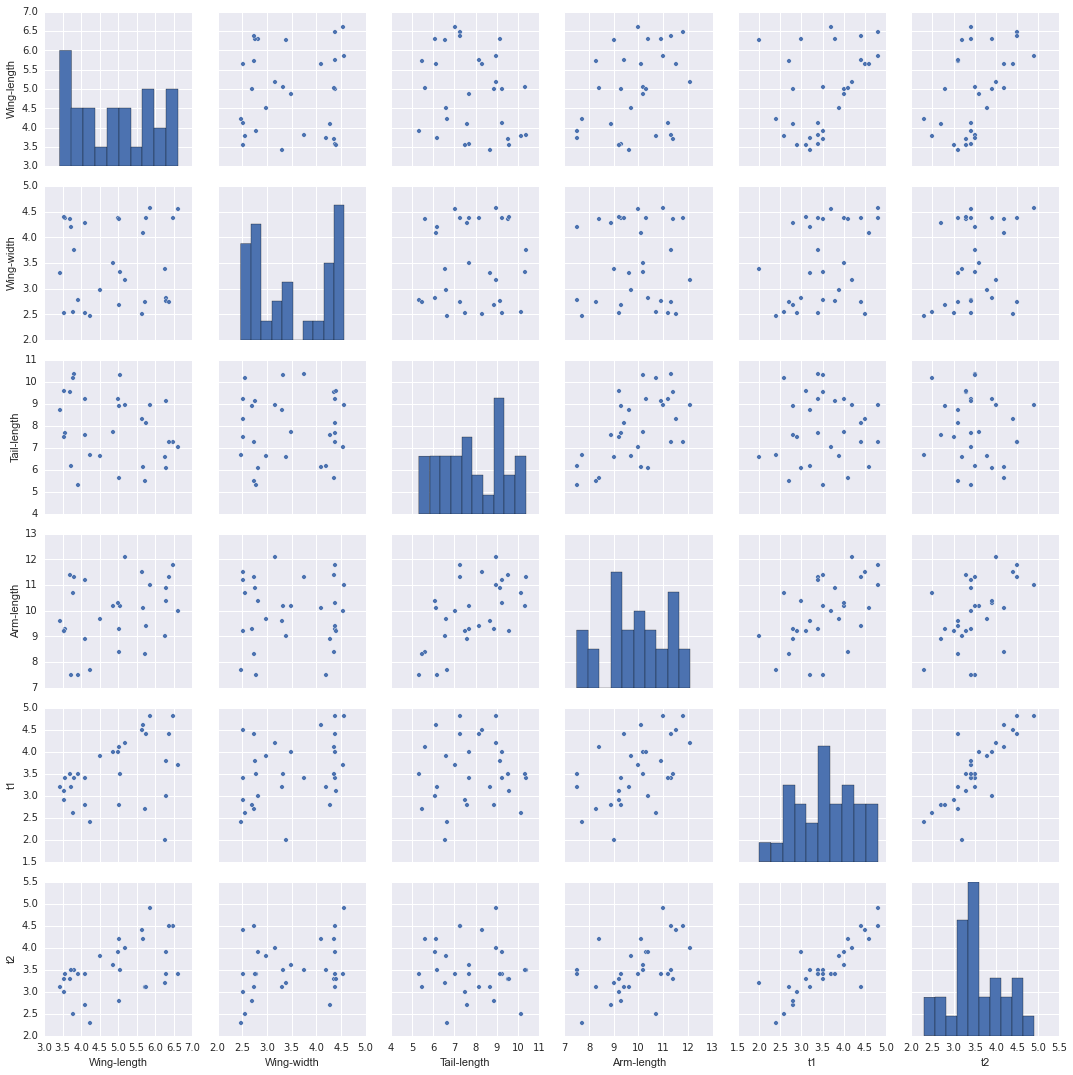

In [148]:
sns.pairplot(data2)

After looking at data we can conclude several things
1. There is a linear correlation between the wing length and the falling time, this linear correlation is also evident between the arm length and the falling time.
2. There is not much noise between the realizations of every experiment.
3. it seems to be a small linear correlation between the arm length and the tail length.

## Q2 Completing linear regression

In [149]:
#########################
## Question 2
def B(x):
    # function returning the matrix of basis functions evaluated at x
    #input:	  x, np.array with d columns
    #output:  a matrix of geberal term B_{i,j} = b_j(x_i)
    b0 = np.ones((x.shape[0],1))
    b1 = (x[:,0])[:,None]
    b2 = np.power(b1, 2)
    #b2 = np.sin(b1)
    B = np.hstack((b0,b1,b2))
    return B

def LR(X,F,B,tau2):
    #input:	  X, np.array with d columns representing the DoE
    #		  F, np.array with 1 column representing the observations
    #		  B, a function returning the (p) basis functions evaluated at x
    # 		  tau2, noise variance
    #output:  beta, estimate of coefficients np.array of shape (p,1)
    #		  covBeta, cov matrix of beta, np.array of shape (p,p)

    # ... to be completed ...
    BB = np.matrix(B(X))
    A = np.linalg.inv(BB.T*BB)
    D = A*(BB.T)
    C = BB*A
    beta = A*D*F
    covBeta = D*tau2*C
    return(beta,covBeta)

t1 = data[:,4]
t2 = data[:,5]
tau2 = np.var(t1 - t2)/2.0
beta, covBeta = LR(X, F, B, tau2)

(10,) (10,)


-32.175761937176631

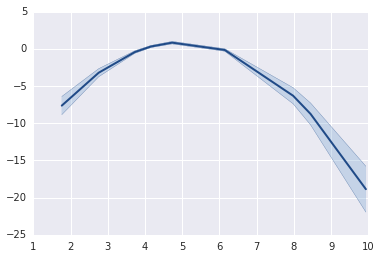

In [150]:
#########################
## Question 3

def predLR(x,B,beta,covBeta):
    #function returning predicted mean and variance
    #input:	  x, np.array with d columns representing m prediction points
    #		  B, a function returning the (p) basis functions evaluated at x
    #		  beta, estimate of the regression coefficients
    # 		  covBeta, covariance matrix of beta
    #output:  m, predicted mean at x, np.array of shape (m,1)
    #		  v, predicted variance matrix, np.array of shape (m,m)

    # ... to be completed ...
    BB = np.matrix(B(x))
    m = BB*beta
    v = BB*covBeta*BB.T
    return(np.asarray(m),np.asarray(v))

def plotModel(x,m,v):
	#input:	  x, np.array with d columns representing m prediction points
	#		  m, predicted mean at x, np.array of shape (m,1)
	#		  v, predicted variance matrix, np.array of shape (m,m)
    x = x.flatten()
    m = m.flatten()
    v = np.diag(v)
    print x.shape, m.shape
    upper=m+2*np.sqrt(v)
    lower=m-2*np.sqrt(v)
    pb.plot(x,m,color="#204a87",linewidth=2)
    pb.fill(np.hstack((x,x[::-1])),np.hstack((upper,lower[::-1])),color="#729fcf",alpha=0.3)
    pb.plot(x,upper,color="#204a87",linewidth=0.2)
    pb.plot(x,lower,color="#204a87",linewidth=0.2)

def R2(X,F,B,beta):
    return(1-sum((F-np.dot(B(X),beta))**2)/sum((F-np.mean(F))**2))

x = np.random.random_sample((10,X.shape[1]))*10.0
x = np.sort(x, axis=0)
mean_pred, cov_pred = predLR(x, B, beta, covBeta)
plotModel(x[:,0:1], mean_pred, cov_pred)
R2(X,F,B,np.asarray(beta))

In [40]:
#########################
## Question 4

def pvalue(beta,covBeta,X):
	df = X.shape[0] - len(beta)
	cdf = stats.t.cdf(np.abs(beta)/np.sqrt(np.diag(covBeta)),df)
	return(2*(1 - cdf))

#########################
## Question 5

## coordinate change
def angle(X):
	# X is Wing-length, Wing-width, Tail-length, Arm-length
	# returns the angle (in degrees) between the tail and the wing
    return(np.pi/180*np.arccos(-1.*((X[:,3]-2.5)**2-(X[:,2]-2.5)**2-X[:,0]**2)/(2*(X[:,2]-2.5)*X[:,0])))

def armLength(X):
	# X is Wing-length, Wing-width, Tail-length, angle (in degrees) between the tail and the wing
	# returns the arm length
	return(np.sqrt(X[:,0]**2+(X[:,2]-2.5)**2-2*np.cos(X[:,3]*180/np.pi)*X[:,0]*(X[:,2]-2.5))+2.5)


#########################
## Question 6